Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
* date_recorded - The date the row was entered
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* wpt_name - Name of the waterpoint if there is one
* num_private -
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* recorded_by - Group entering this row of data
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

Distribution of Labels  
The labels in this dataset are simple. There are three possible values:

* functional - the waterpoint is operational and there are no repairs needed
* functional needs repair - the waterpoint is operational, but needs repairs
* non functional - the waterpoint is not operational

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

In [3]:
train_values_df = pd.read_csv('training_set_values.csv')
train_labels_df = pd.read_csv('training_set_labels.csv')

In [4]:
train_values_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
train_labels_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
features_to_drop = []

### Explore target variable

In [7]:
target_col = 'status_group'

In [8]:
train_labels_df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

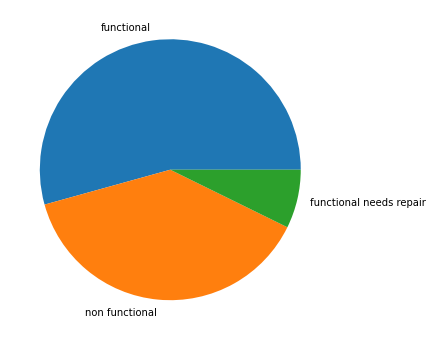

In [9]:
plt.figure(figsize=(6, 6))
plt.pie(train_labels_df[target_col].value_counts(), labels=train_labels_df[target_col].unique())
plt.show()

Imbalanced multiclass classification dataset

Need to balance the dataset before training classifier.  
1. subsampling (taking a smaller yet equal selection of samples from each class)  
1. upsampling (taking repeat samples from some classes to increase its numbers)  
1. resampling (using an algorithm like SMOTE to augment the dataset with artificial data)

### Explore dataset 

In [10]:
train_values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

A lot of categorical columns  
I will preprocess them later in order to increase baseline precision given by numeric data

Exploring missing values

In [11]:
features_to_drop.append('id')

In [12]:
# Merge values and labels into one df
train_df = pd.merge(train_values_df, train_labels_df, on='id')
train_df.drop('id', axis=1, inplace=True)

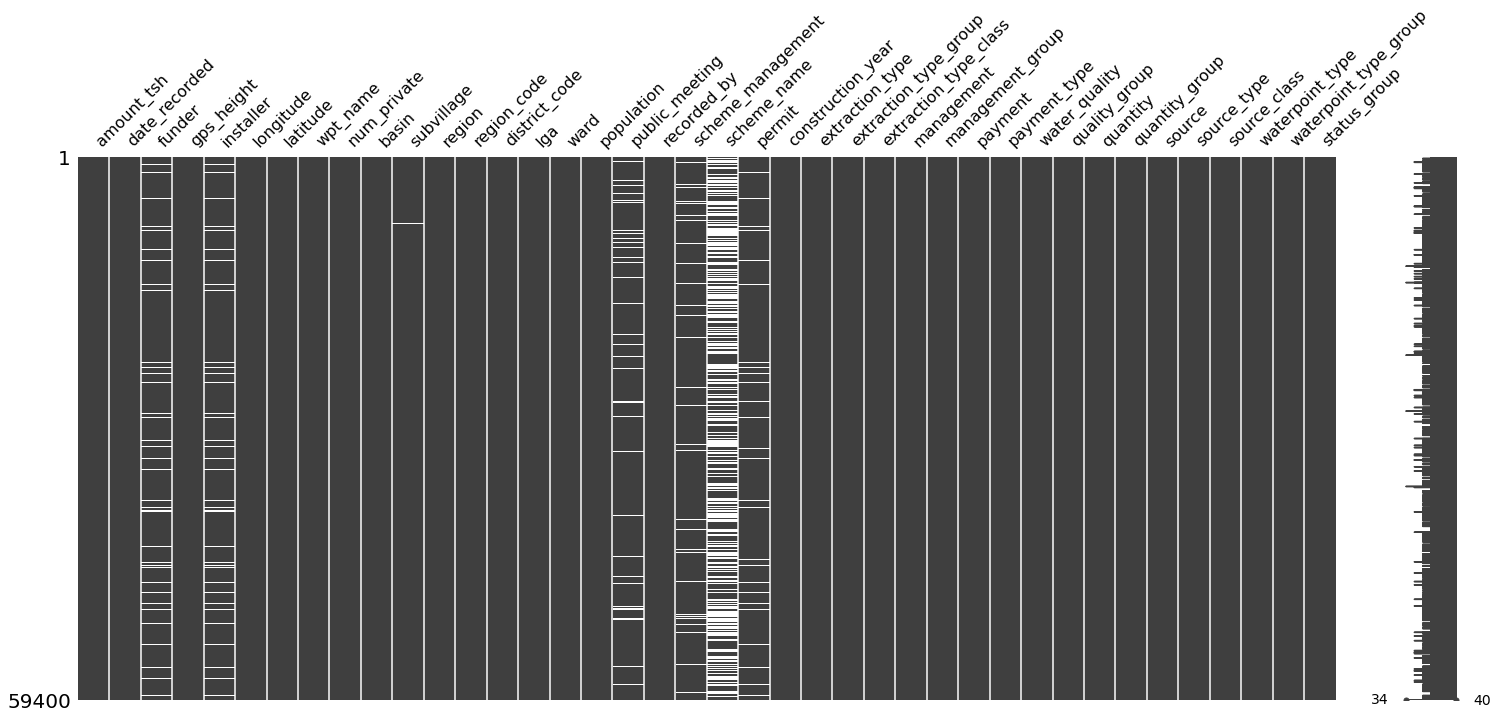

In [13]:
# Explore the missing values
msno.matrix(train_df)

"scheme_name" column contains a lot of missing values

In [14]:
print("scheme_name missings = {}".format(train_df['scheme_name'].isna().sum()/train_df.shape[0]))

scheme_name missings = 0.4741750841750842


It's more rational to delete "scheme_name" categorical column, than drop NaN rows

In [15]:
features_to_drop.append('scheme_name')

In [16]:
train_df.drop('scheme_name', axis=1, inplace=True)

Drop rows with NaN values

In [17]:
train_df.dropna(inplace=True)

Plot numerical columns distributions

In [18]:
import math
import warnings
warnings.filterwarnings('ignore')

In [19]:
fig_dist_n_cols = 3
fig_dist_n_rows = math.ceil(len(train_df.select_dtypes(exclude=['object']).columns)/fig_dist_n_cols)

amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year


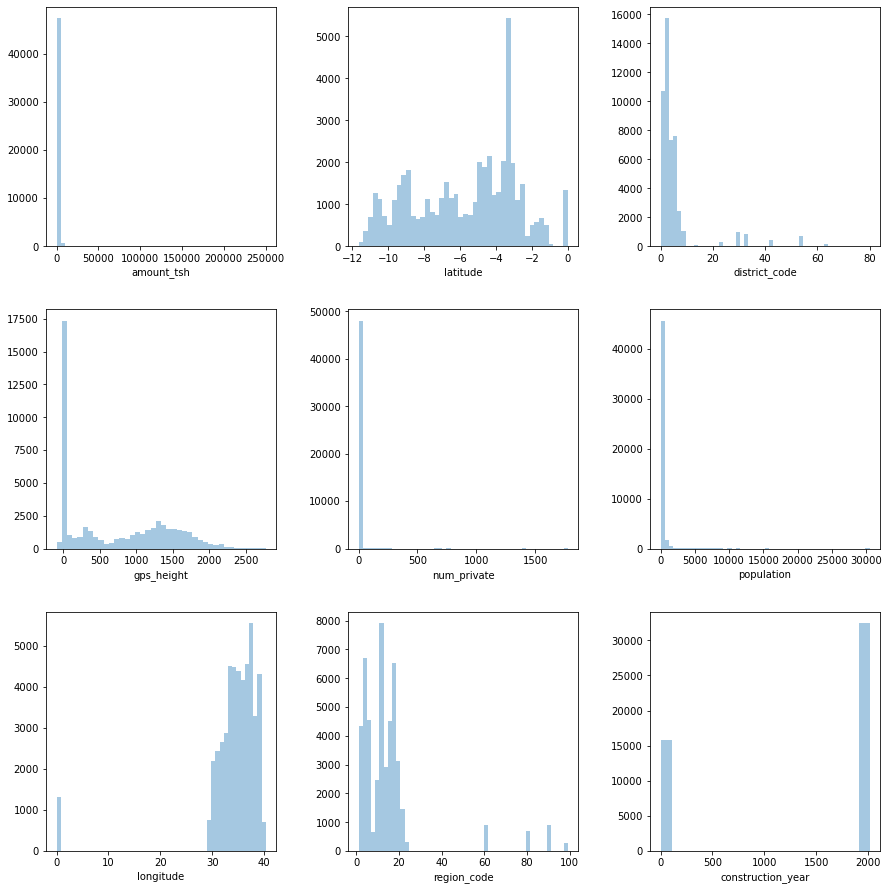

In [20]:
fig, ax = plt.subplots(fig_dist_n_rows, fig_dist_n_cols, figsize=(13, 13))

for i, col in enumerate(train_df.select_dtypes(exclude=['object']).columns):
    print(col)
    col_idx = math.floor(i / fig_dist_n_rows)
    row_idx = i % fig_dist_n_cols
    sns.distplot(train_df[col], kde=False, ax=ax[row_idx, col_idx])
    
fig.tight_layout(pad=3.0)
plt.show()

In [21]:
for col in ['amount_tsh', 'gps_height', 'population']:
    top_col_cnt = train_df[col].value_counts()[0]
    top_col_val = train_df[col].value_counts().index[0]
    print('Column: {}\n\t{} : {}\n'.format(col, top_col_val, top_col_cnt))

Column: amount_tsh
	0.0 : 32151

Column: gps_height
	0 : 15783

Column: population
	0 : 16724



"amount_tsh" contains a lot of 0 values  
"gps_height" contains lot of 0 values  
"population" contains a lot of 0 values  
"longitude" contains enough 0 values, although they describe Taarifa GPS coordinates and should be pretty same  
"construction_year" contains enough 0 values, that seems to be NaN replaced by constant  


Plot longitude and latitude GPS coordinates

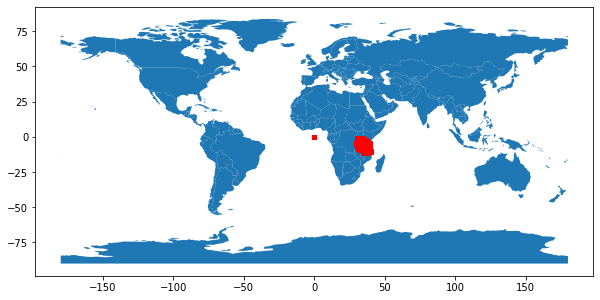

In [22]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(train_df['longitude'], train_df['latitude'])]
gdf = GeoDataFrame(train_df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

According to the plot above, "longitude" 0 values are wrong values and should be cleaned

In [23]:
train_df = train_df[train_df.longitude != 0]

Replace 0 values with NaNs in:
- "amount_tsh"
- "gps_height"
- "population"
- "construction_year"

In [24]:
geographic_cols_to_fill = ['amount_tsh', 'gps_height', 'population', 'construction_year']

In [25]:
def replace_zeros_with_nan(df, cols):
    for col in cols:
        df[col] = df[col].where(df[col] != 0)

Add missing indicator

In [26]:
def add_missing_indicator(df, cols):
    for col in cols:
        df[col + "_nan"] = (~df[col].isnull()).astype(int)

Geographic data columns that might help to restore NaN values: 

In [27]:
train_df[['basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward']].nunique()

basin                9
subvillage       15645
region              21
region_code         27
district_code       18
lga                116
ward              1806
dtype: int64

Replace values with median of a certain groups 

In [28]:
def replace_nan_with(df, cols, method='median'):
    for col in cols:
        df[col].fillna(df.groupby(['basin', 'region_code', 'district_code'])[col].transform(method), inplace=True)

        df[col].fillna(df.groupby(['region_code', 'district_code'])[col].transform(method), inplace=True)

        df[col].fillna(df.groupby(['basin', 'region_code'])[col].transform(method), inplace=True)

        df[col].fillna(df.groupby(['basin', 'district_code'])[col].transform(method), inplace=True)

        df[col].fillna(df.groupby(['region_code'])[col].transform(method), inplace=True)

In [29]:
def preprocess_geographical_cols(df, cols, method='median'):
    replace_zeros_with_nan(df, cols)
    add_missing_indicator(df, cols)
    replace_nan_with(df, cols, method)
    return df

In [30]:
train_df = preprocess_geographical_cols(train_df, geographic_cols_to_fill)

Check the result of the imputation

In [31]:
for col in geographic_cols_to_fill:
    print("Column: {}\n\t{}".format(col, train_df[col].value_counts().index[0]))

Column: amount_tsh
	500.0
Column: gps_height
	19.0
Column: population
	1.0
Column: construction_year
	2011.0


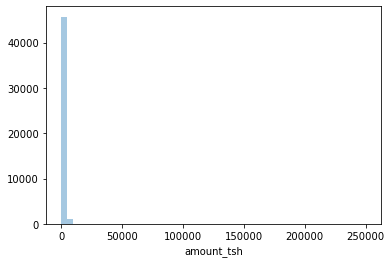

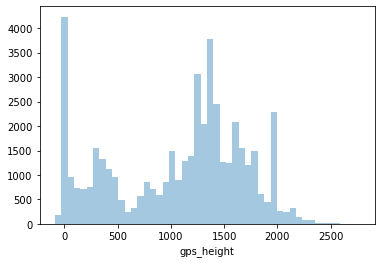

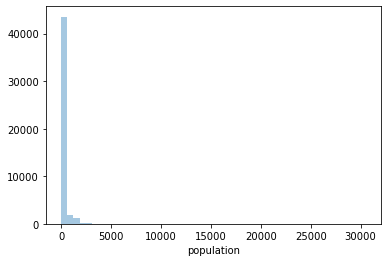

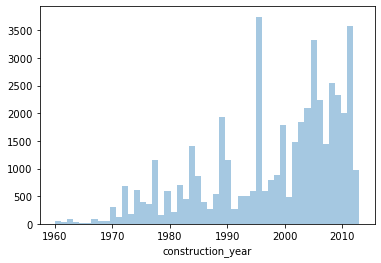

In [32]:
for col in geographic_cols_to_fill:
    plt.figure()
    sns.distplot(train_df[col], kde=False)

### Explore categorical variables 

In [34]:
cat_cols = train_df.drop(target_col, axis=1).select_dtypes(include=['object']).columns

In [35]:
for col in cat_cols:
    print("{}: {} unique".format(col, train_df[col].nunique()))

date_recorded: 321 unique
funder: 1555 unique
installer: 1757 unique
wpt_name: 30514 unique
basin: 9 unique
subvillage: 15645 unique
region: 21 unique
lga: 116 unique
ward: 1806 unique
public_meeting: 2 unique
recorded_by: 1 unique
scheme_management: 12 unique
permit: 2 unique
extraction_type: 18 unique
extraction_type_group: 13 unique
extraction_type_class: 7 unique
management: 12 unique
management_group: 5 unique
payment: 7 unique
payment_type: 7 unique
water_quality: 8 unique
quality_group: 6 unique
quantity: 5 unique
quantity_group: 5 unique
source: 10 unique
source_type: 7 unique
source_class: 3 unique
waterpoint_type: 7 unique
waterpoint_type_group: 6 unique


Convert date_recorded to datetime object

In [36]:
cols_to_datetime = ['date_recorded']

In [37]:
def convert_to_datetime(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col]) 

In [38]:
convert_to_datetime(train_df, cols_to_datetime)

Convert boolen categorical columns to integer

In [39]:
bool_cols = []

for col in cat_cols:
    if train_df[col].nunique() == 2:
        bool_cols.append(col)

In [40]:
def convert_bool_to_int(df, cols):
    for col in cols:
        df[col] = df[col].astype(int)

In [41]:
convert_bool_to_int(train_df, bool_cols)

"wpt_name" and "subvillage" columns contain a lot of unique values

In [42]:
features_to_drop.append(['wpt_name', 'subvillage'])

In [43]:
train_df.drop(['wpt_name', 'subvillage'], axis=1, inplace=True)

Drop "recorded_by" with only 1 unique value

In [44]:
features_to_drop.append('recorded_by')

In [45]:
train_df.drop(['recorded_by'], axis=1, inplace=True)

Update categorical columns list

In [46]:
cat_cols = train_df.drop(target_col, axis=1).select_dtypes(include=['object']).columns

Convert categorical columns to lower case

In [47]:
def cat_cols_to_lower(df, cols):
    for col in cols:
        df[col] = df[col].str.lower()

In [48]:
cat_cols_to_lower(train_df, cat_cols)

In [49]:
small_nunique_cat_cols = [col for col in cat_cols if train_df[col].nunique() < 25]

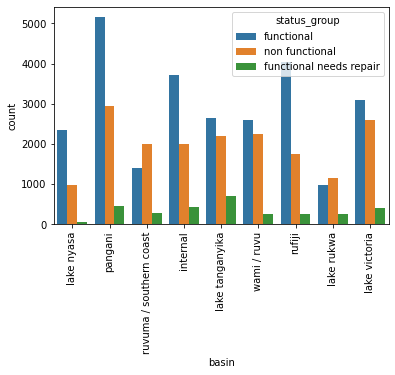

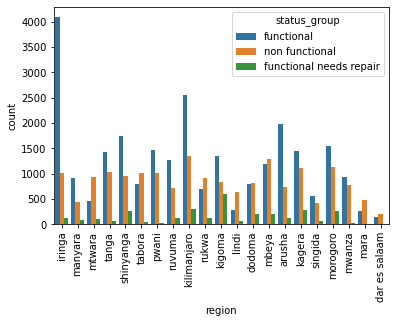

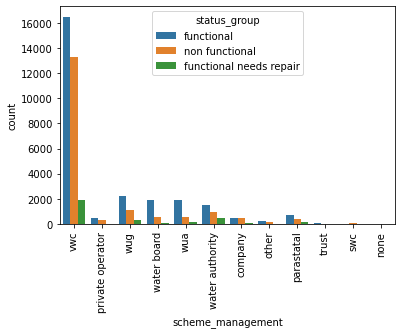

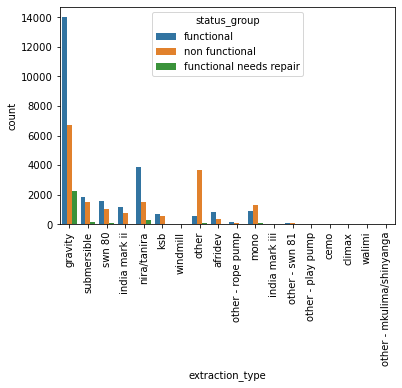

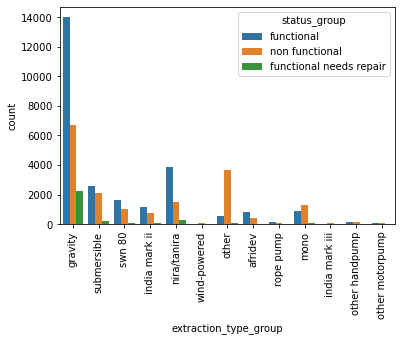

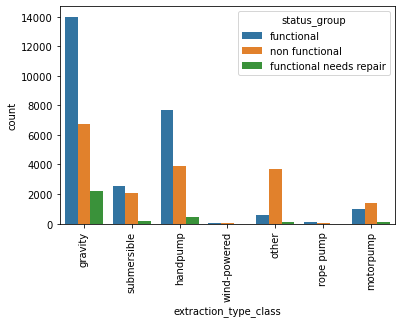

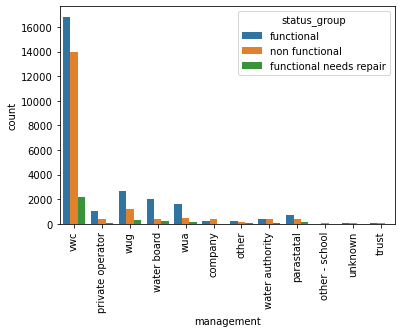

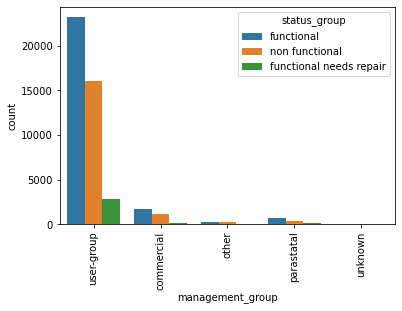

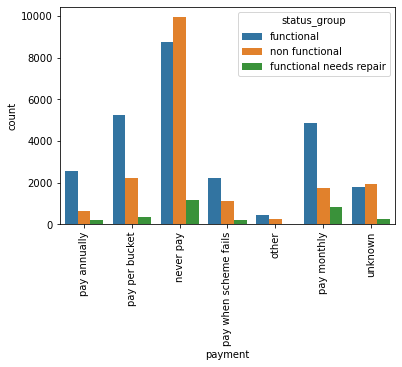

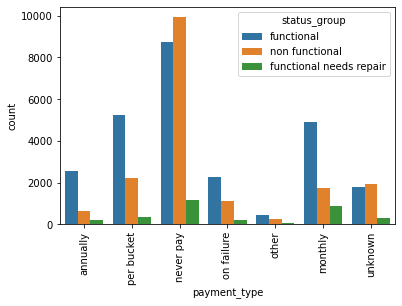

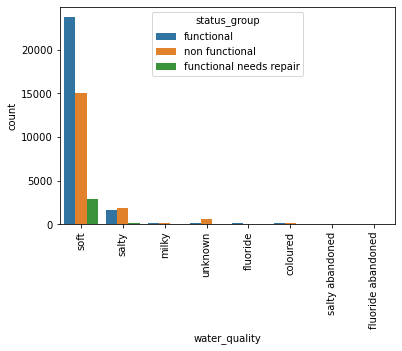

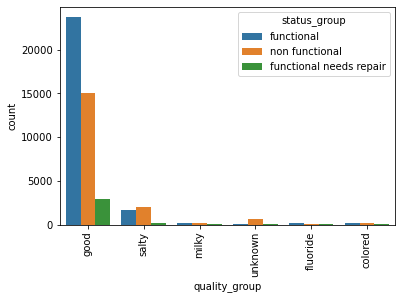

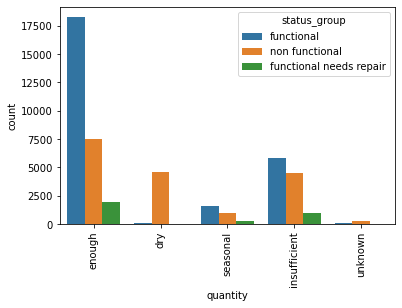

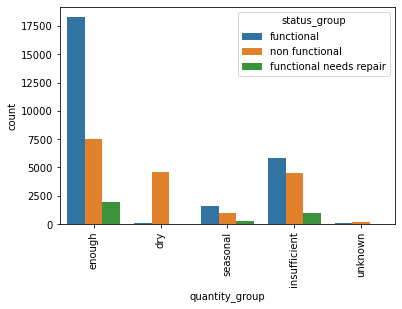

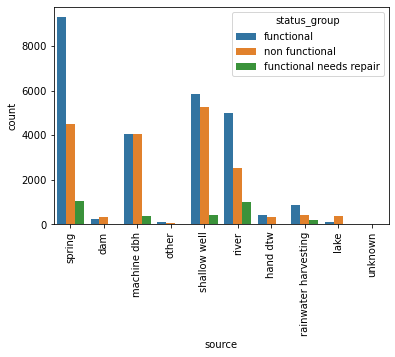

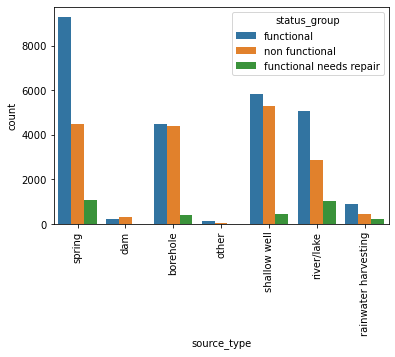

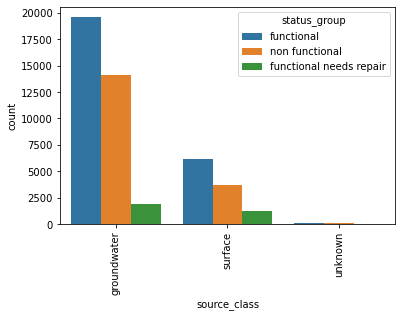

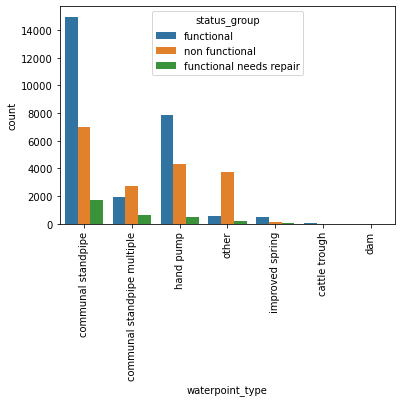

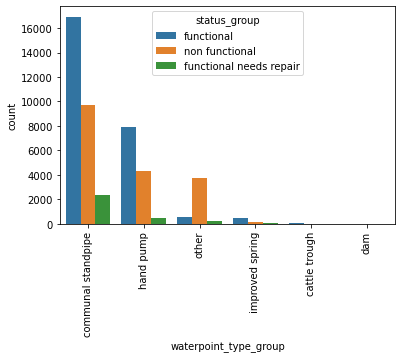

In [50]:
for col in small_nunique_cat_cols:
    plt.figure()
    sns.countplot(train_df[col], hue=train_df[target_col])
    plt.xticks(rotation=90)

Some features seems to be highly correlated

Cramer's V is a way of calculating correlation between categorical columns

In [52]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

In [53]:
cat_corr_df = pd.DataFrame(index=train_df[cat_cols].columns, columns=train_df[cat_cols].columns)
cat_corr_df = cat_corr_df.fillna(0)

In [54]:
for row in cat_corr_df.index:
    for col in cat_corr_df.columns:
        cat_corr_df.loc[row, col] = cramers_v(train_df[row], train_df[col])
#         print("[{}, {}] = {}".format(row, col, cols_corr_df.loc[row, col]))
    print(row)

funder
installer
basin
region
lga
ward
scheme_management
extraction_type
extraction_type_group
extraction_type_class
management
management_group
payment
payment_type
water_quality
quality_group
quantity
quantity_group
source
source_type
source_class
waterpoint_type
waterpoint_type_group


In [ ]:
import plotly.express as px
fig = px.imshow(cat_corr_df)
fig.show()

#### Drop highly correlated categorical columns

In [55]:
upper_cat_corr_df = cat_corr_df.where(np.triu(np.ones(cat_corr_df.shape), k=1).astype(np.bool))

In [56]:
corr_values = []
for col in upper_cat_corr_df.columns:
    corr_values.append(upper_cat_corr_df[col].unique().tolist())

In [57]:
corr_values_list = [item for sublist in corr_values for item in sublist]

Choose threshold

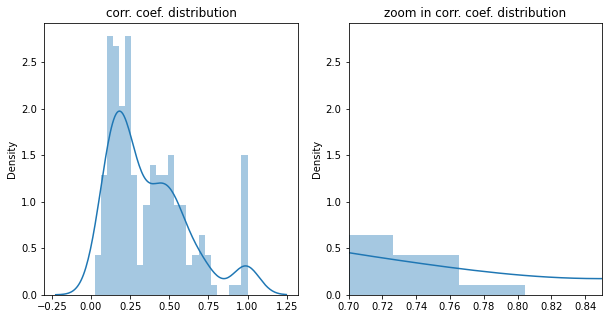

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(corr_values_list, bins=25, kde=True, ax=ax1)
sns.distplot(corr_values_list, bins=25, kde=True, ax=ax2)
ax2.set_xlim(0.7, 0.85)
ax1.set_title('corr. coef. distribution')
ax2.set_title('zoom in corr. coef. distribution')
plt.show()

According to the plot above, threshold for highly correlated features is about 0.76

In [59]:
cat_threshold = 0.76

Find attributes with correlation above the threshold

In [60]:
cat_corr_above_thresh = upper_cat_corr_df.ge(cat_threshold).any(axis=1)

In [61]:
cat_feat_to_drop = cat_corr_above_thresh.index[cat_corr_above_thresh == True].tolist()

In [62]:
cat_feat_to_drop

['basin',
 'region',
 'lga',
 'extraction_type',
 'extraction_type_group',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'source_type',
 'waterpoint_type']

Drop categorical features

In [63]:
features_to_drop.append(cat_feat_to_drop)

In [64]:
train_df.drop(cat_feat_to_drop, axis=1, inplace=True)

In [65]:
train_df.head(1).T

,0
amount_tsh,6000.0
date_recorded,2011-03-14 00:00:00
funder,roman
gps_height,1390.0
installer,roman
longitude,34.938093
latitude,-9.856322
num_private,0
region_code,11
district_code,5


Explore dependence between month recorded and target variable

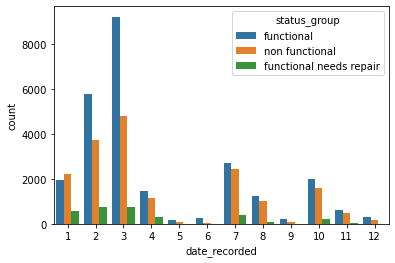

In [66]:
plt.figure()
sns.countplot(train_df['date_recorded'].dt.month, hue=train_df[target_col])

Explore dependence between number of years waterpipe is installed and target variable

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 <a list of 68 Text major ticklabel objects>)

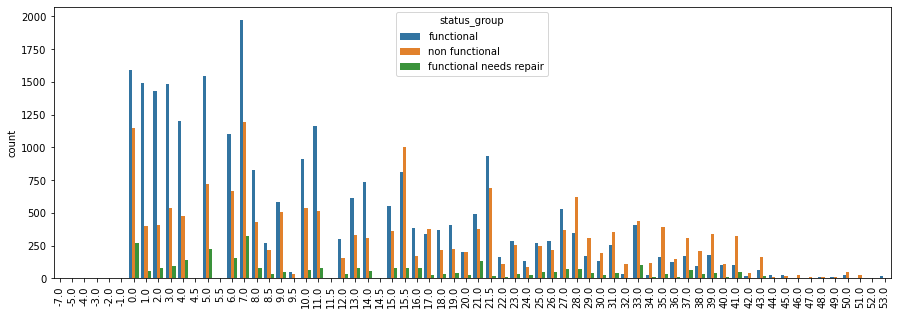

In [68]:
plt.figure(figsize=(15, 5))
sns.countplot(train_df['date_recorded'].dt.year-train_df['construction_year'], hue=train_df[target_col])
plt.xticks(rotation=90)

In [133]:
def preprocess_date(df, cols):
    for col in cols:
        df['date_recorded_month'] = df[col].dt.month
        df['years_installed'] = (df[col].dt.year - df['construction_year']).round()

In [ ]:
preprocess_date(train_df, cols_to_datetime)

Drop rows with incorrectly inserted "construction_year"

In [70]:
train_df = train_df[train_df['years_installed'] > 0]

In [71]:
features_to_drop.append('date_recorded')

In [72]:
train_df.drop(['date_recorded'], axis=1, inplace=True)

In [73]:
train_df.drop(['geometry'], axis=1, inplace=True)

Preprocessed data

In [74]:
X = train_df.drop([target_col], axis=1)
y = train_df[target_col]

In [75]:
from sklearn.preprocessing import LabelEncoder

In [76]:
target_col_encoder = LabelEncoder()

y = target_col_encoder.fit_transform(y)

Apply preprocessing to train data

In [134]:
test_df = pd.read_csv('test_set_values.csv')

In [135]:
submit_id = test_df['id'].copy()

In [136]:
test_df.fillna(0, inplace=True)

In [137]:
test_df = preprocess_geographical_cols(test_df, geographic_cols_to_fill)

In [138]:
convert_to_datetime(test_df, cols_to_datetime)

In [139]:
preprocess_date(test_df, cols_to_datetime)

In [140]:
convert_bool_to_int(test_df, bool_cols)

In [141]:
cat_cols_to_lower(test_df, cat_cols)

In [142]:
for col in features_to_drop:
    test_df.drop(col, axis=1, inplace=True)

Encode categorical data

In [143]:
test_df['is_test'] = 1

In [144]:
test_df.head(1).T

,0
amount_tsh,20.0
funder,dmdd
gps_height,1996.0
installer,dmdd
longitude,35.290799
latitude,-4.059696
num_private,0
region_code,21
district_code,3
ward,bashay


In [145]:
train_test_concat = pd.concat([X, test_df])

In [146]:
cat_cols_to_encode = train_test_concat.select_dtypes(include=['object']).columns

In [147]:
for col in cat_cols_to_encode:
    train_test_concat[col] = pd.factorize(train_test_concat[col])[0]

In [150]:
X_test = train_test_concat.loc[train_test_concat['is_test'] == 1]
X_test.drop('is_test', axis=1, inplace=True)

In [160]:
X_train = train_test_concat.loc[train_test_concat['is_test'].isnull()]
X_train.drop('is_test', axis=1, inplace=True)

In [162]:
X_train.shape

(43940, 28)

In [163]:
X_test.shape

(14850, 28)

### Models

Algorithms that can be used for multi-class classification include:

- Decision Trees.
- Naive Bayes.
- Random Forest.
- Gradient Boosting.

In [153]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [164]:
multiclass_clf_algorithms = {'RandomForestClassifier': RandomForestClassifier(), 
                             'DecisionTreeClassifier': DecisionTreeClassifier(), 
                             'XGBClassifier': XGBClassifier(objective = 'multi:softmax')}


In [165]:
cv_results = []
skf_cv = StratifiedKFold(n_splits=5, random_state=0)

for clf_name, clf_model in multiclass_clf_algorithms.items():
    print(clf_name)
    cv_scores = cross_val_score(clf_model, X_train, y, scoring='accuracy', cv=skf_cv)
    cv_results.append([clf_name, cv_scores])

RandomForestClassifier
DecisionTreeClassifier
XGBClassifier


In [166]:
cv_results

[['RandomForestClassifier',
  array([0.81065089, 0.80393719, 0.80666818, 0.80359581, 0.80609923])],
 ['DecisionTreeClassifier',
  array([0.7594447 , 0.75512062, 0.75364133, 0.74886208, 0.74681384])],
 ['XGBClassifier',
  array([0.74965863, 0.75170687, 0.74715521, 0.74704142, 0.75830678])]]

#### Apply baseline model for prediction

In [168]:
rf_clf = RandomForestClassifier()

In [169]:
rf_clf.fit(X_train, y)

RandomForestClassifier()

In [170]:
y_pred = rf_clf.predict(X_test)

In [171]:
y_pred_encoded = target_col_encoder.inverse_transform(y_pred)

Submission

In [174]:
submit_df = pd.concat([submit_id, pd.Series(y_pred_encoded, name=target_col)], axis=1)

In [175]:
submit_df.to_csv("rfc_submission__baseline.csv" , index=False)

Score: 0.7776

#### Baseline using SMOTE for oversampling

In [178]:
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=[X_train.columns.get_loc(c) for c in cat_cols_to_encode], random_state=0)
X_train_oversampled, y_oversampled = smote_nc.fit_resample(X_train, y)

In [179]:
rf_clf.fit(X_train_oversampledampled, y_oversampled)

RandomForestClassifier()

In [181]:
y_pred = rf_clf.predict(X_test)

In [182]:
y_pred_encoded = target_col_encoder.inverse_transform(y_pred)

Submission

In [183]:
submit_df[target_col] = y_pred_encoded

In [184]:
submit_df.to_csv("rfc_submission__baseline.csv" , index=False)

Score: 0.7587

#### Grid search for RandomForest

In [195]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

criterion = ['gini', 'entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [196]:
rf_random = RandomizedSearchCV(estimator=rf_clf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=skf_cv,
                               verbose=1,
                               scoring='accuracy',
                               random_state=42,
                               n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 65.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 148.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 175.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                          

In [197]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'entropy',
 'bootstrap': False}

In [198]:
rf_random.best_score_

0.8159763313609467

In [199]:
y_pred = rf_random.predict(X_test)

In [200]:
y_pred_encoded = target_col_encoder.inverse_transform(y_pred)

Submission

In [201]:
submit_df[target_col] = y_pred_encoded

In [202]:
submit_df.to_csv("rfc_submission__randomized_search.csv" , index=False)

Score: 0.7857